In [1]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import logging
import datetime
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import chi2
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error 
from sklearn.inspection import permutation_importance

In [2]:
df = pd.read_csv(r"C:\Users\白猪白猪\Documents\Documents\CMSE802\Class_Material\Homework\Project\Data\reduced_data.csv")

# convert categorical variables into numerical values
label_encoders = {}
for column in df.columns[:2]:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Feature Selection and Target Variable
X = df.iloc[:, :-3]
y = df.iloc[:, -2]

In [ ]:
# print the codes for each categorical variable
for column, le in label_encoders.items():
    print(f"Column: {column}")
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print("Mapping:", mapping)
    print()


Column: Plant Species
Mapping: {'Cabbage': 0, 'Chinese Cabbage': 1, 'Chrysanthemum coronarium (Crown Daisy)': 2, 'Cucumber': 3, 'Lettuce': 4, 'Red Chicory': 5, 'Spinach': 6, 'Tomato': 7, 'Zucchini': 8}

Column: Functional Group
Mapping: {'Carboxylate': 0, 'Sulfonate': 1}



In [3]:
#Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Set Up Logger**

In [ ]:
logger = logging.getLogger('XGBoost_SCF_gridsearch') #  Create a logger object named 'XGBoost_gridsearch'
logger.setLevel(logging.INFO) # set its logging level to INFO

# Create a file handler object
handler = logging.FileHandler(r'D:\新建文件夹\LR\XGBoost_TF_gridsearch.log')
handler.setLevel(logging.INFO)

# Add the file handler to the logger
logger.addHandler(handler)

**Initialize XGBoost Regressor**

In [ ]:
model2 = XGBRegressor(n_estimators= 100,random_state=100,early_stopping_rounds=10)
# 100 decision trees (n_estimators)
# a specified random state for reproducibility (random_state)
#  early stopping after 10 rounds if there is no improvement in the model's performance (early_stopping_rounds)

**Search for optimal parameters**

In [ ]:
# Search for optimal parameters-n_estimators & learning_rate & max_depth & min_child_weight
# Round 1
param_grid = {
    'n_estimators': range(10, 310, 10),
    'learning_rate': [0.1],
    'max_depth': range(1, 21, 2),
    'min_child_weight': range(1, 12, 2),
}

In [ ]:
# Round 2
param_grid = {
    'n_estimators': range(70, 91, 1),
    'learning_rate': [0.1],
    'max_depth': range(1, 6, 1),
    'min_child_weight': range(1, 6, 1),
}

**Calculate the total number of hyperparameter combinations and the total number of model**

In [ ]:
num_combinations = len(list(itertools.product(*param_grid.values())))
cv = 10
total_fits = num_combinations * cv

**Log Parameter Grid and Search Settings**

In [ ]:
logger.info("\nParameter grid: %s", param_grid)
logger.info("CV: %d", cv)
logger.info("Total number of fits: %d", total_fits)

**Define a custom class TqdmUpTo that extends the tqdm progress bar**

In [ ]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

**Grid Search**

In [ ]:
with TqdmUpTo(unit='B', unit_scale=True, miniters=1, desc='GridSearchCV') as t:
     
    # Record the start time of the grid search and log it
    start_time = datetime.datetime.now()
    logger.info("Start time: %s", start_time)
    
    #Perform Grid Search, with the XGBoost model, cross-validation, and evaluation on a test set
    grid_search = GridSearchCV(model2, param_grid=param_grid, cv=cv, n_jobs=1, verbose=2)
    grid_search.fit(X_train, Y_train.values.ravel(),eval_set=[(X_test, Y_test)],verbose=False)
    
    #  Record the end time of the grid search and log it
    end_time = datetime.datetime.now()
    logger.info("End time: %s", end_time)

    # Calculate and log the total time
    total_time = end_time - start_time
    logger.info("Total run time: %s", total_time)

**Log the best parameters found by the grid search and the corresponding best score**

In [ ]:
logger.info("Best parameters: %s", grid_search.best_params_)
logger.info("Best score: %f\n", grid_search.best_score_)

**Define Best Parameters determined from the grid search**

In [4]:
best_params = {
    'n_estimators': 79,
    'learning_rate': 0.1,
    'max_depth': 3,
    'min_child_weight': 3, 
    'random_state':100
}
# Initialize XGBoost Regressor with Best Parameters
model3 = XGBRegressor(**best_params)
# Fit the model on the training set
model3.fit(X_train,Y_train.values.ravel())

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=79, n_jobs=None,
             num_parallel_tree=None, random_state=100, ...)

**Evaluate the XGBoost Model's Performance**

In [5]:
# make predictions on the test set X_test
y_pred = model3.predict(X_test)

# prints various metrics
mse = mean_squared_error(Y_test, y_pred)
print(f"Mean square error of the prediction set: {mse}")
rmse = np.sqrt(mse)
print(f"Root-mean-square error of the prediction set: {rmse}")
mae = mean_absolute_error(Y_test, y_pred)
print(f"Mean absolute error of the prediction set: {mae}")
r2 = r2_score(Y_test, y_pred)
print(f"R² score of the prediction set: {r2}")

# make predictions on the training set X_train
y_train_pred = model3.predict(X_train)
mse_train = mean_squared_error(Y_train, y_train_pred)
print(f"Mean square error of the training set: {mse_train}")
rmse_train = np.sqrt(mse_train)
print(f"Root mean square error of the training set: {rmse_train}")
mae_train = mean_absolute_error(Y_train, y_train_pred)
print(f"Mean absolute error of the training set: {mae_train}")
r2_train = r2_score(Y_train, y_train_pred)
print(f"R² score of the training set: {r2_train}")

Mean square error of the prediction set: 0.0007537057572791137
Root-mean-square error of the prediction set: 0.02745370206873954
Mean absolute error of the prediction set: 0.011313008632590157
R² score of the prediction set: 0.5389503289279787
Mean square error of the training set: 0.00026085086732163186
Root mean square error of the training set: 0.016150878221373347
Mean absolute error of the training set: 0.006596781040556712
R² score of the training set: 0.6493447959822363


**Save DataFrame for predicted values to Excel**

In [ ]:
# Export and save the test set's prediction results to an Excel file
df_comparison = pd.DataFrame({'Actual': Y_test.values.flatten(), 'Predicted': y_pred})
output_excel_path =r'C:\Users\白猪白猪\Documents\Documents\CMSE802\Class_Material\Homework\Project\Data\XGBoost_SCF_predictions.xlsx'
df_comparison.to_excel(output_excel_path, index=False)

In [ ]:
# Create a scatter plot to compare actual and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(df_comparison['Actual'], df_comparison['Predicted'], alpha=0.5, color='blue', label='Predictions')

# Add a 45-degree line to represent perfect predictions
plt.plot([df_comparison['Actual'].min(), df_comparison['Actual'].max()], 
         [df_comparison['Actual'].min(), df_comparison['Actual'].max()], 
         'r--', label='Perfect Prediction Line')

# Add title and labels
plt.title('Actual vs Predicted Values', fontsize=16)
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)

# Add legend
plt.legend()

# Save the plot to an Excel file
output_excel_plot_path = r'C:\Users\白猪白猪\Documents\Documents\CMSE802\Class_Material\Homework\Project\Data\XGBoost_SCF_predictions.xlsx'
plt.savefig(output_excel_plot_path, bbox_inches='tight')

# Show the plot
plt.show()

**Evaluating and Visualizing feature importances--(1)Gain**

Feature Ranking:
1. Feature 5 (0.723772)
2. Feature 2 (0.101791)
3. Feature 0 (0.084681)
4. Feature 3 (0.049529)
5. Feature 4 (0.028905)
6. Feature 1 (0.011323)


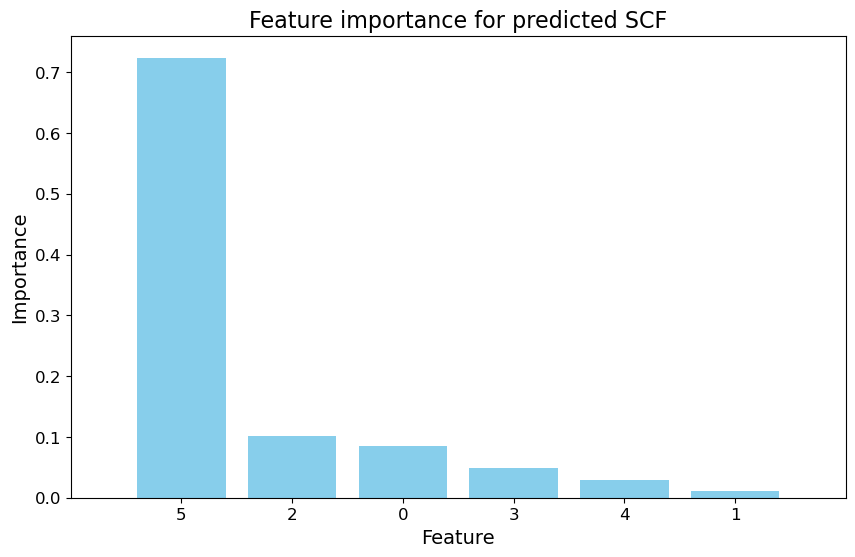

In [7]:
# Retrieve Feature Importances from the Xgboost model
importances = model3.feature_importances_
# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

#Print Feature Ranking
print("Feature Ranking:")
for f in range(X_train.shape[1]):
    print("%d. Feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.figure(figsize=(10, 6))
plt.title("Feature importance for predicted SCF", fontsize=16)
plt.bar(range(X_train.shape[1]), importances[indices], color="skyblue", align="center")
plt.xticks(range(X_train.shape[1]), indices, fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([-1, X_train.shape[1]])
plt.ylabel('Importance', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.show()

**Evaluating and Visualizing feature importances--(2)permutation_importance**

Feature Ranking:
5       0.960 +/- 0.058
2       0.180 +/- 0.019
0       0.093 +/- 0.020
3       0.040 +/- 0.006
4       0.005 +/- 0.002
1       0.001 +/- 0.000


Text(0.5, 0, 'Feature')

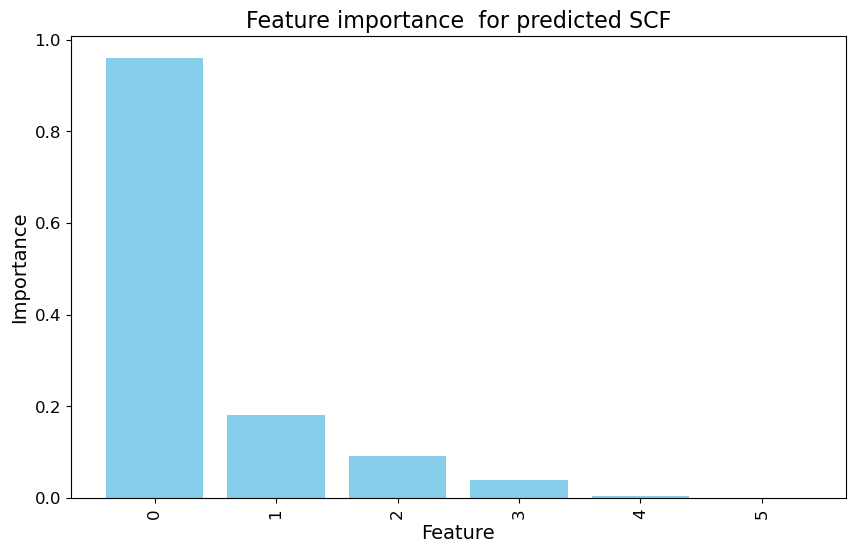

In [6]:
# Use the permutation_importance function to calculate the importance of each feature
importances = permutation_importance(model3, X_train, Y_train,scoring='explained_variance', n_repeats=20, random_state=100, n_jobs=1)

indices = np.argsort(importances.importances_mean)[::-1]

# Print the ranking of features along with their mean importance scores and standard deviations
print("Feature Ranking:")
for i in indices:
    if importances.importances_mean[i] - 2 * importances.importances_std[i] > 0:
        print(f"{i:<8}"
              f"{importances.importances_mean[i]:.3f}"
              f" +/- {importances.importances_std[i]:.3f}")

plt.figure(figsize=(10, 6))
plt.title("Feature importance  for predicted SCF", fontsize=16)
plt.bar(range(X_train.shape[1]), importances.importances_mean[indices], color="skyblue", align="center")
plt.xticks(range(X_train.shape[1]), range(X_train.shape[1]), fontsize=12, rotation='vertical')
plt.yticks(fontsize=12)
plt.ylabel('Importance', fontsize=14)
plt.xlabel('Feature', fontsize=14)